<a href="https://colab.research.google.com/github/pipeton8/6.864-advanced-nlp/blob/main/Assignments/Assignment%200/hw0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to **Homework 0**, interactive edition! In this assignment, we will introduce you to PyTorch and review dynamic programming.

Throughout 6.864, we will use **Google Colab** for the programming and modeling parts of homework assignments. Colab notebooks are just like regular IPython notebooks, but they are executed on Google servers instead of on your local machine. The nice part about this is that Colab offers free GPU support, allowing you to quickly edit-refresh-run  machine learning code without your own CUDA-compatible GPU.

**We suggest you run this homework assignment on a GPU.** To do so, follow these steps:
1. Under the "Runtime" menu, select "Change runtime type"
1. In the "Hardware accelerator" dropdown select "GPU"
1. Rerun any cells you ran previously in the notebook.

Then you're good to go! The next two cells install some dependencies for this project and configure it.

In [1]:
!pip install torch matplotlib seaborn sklearn

In [2]:
import torch
from torch import cuda

if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

# Part 1: PyTorch

We'll first cover the basics of [PyTorch](https://pytorch.org/), a popular machine learning framework. All programming assignments in this class will use PyTorch for modeling and optimization. Before you proceed with this section, we strongly suggest you complete the [60 minute deep learning tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) provided by the PyTorch developers. That tutorial is relatively comprehensive; we'll cover only the most essential concepts from the library.

A simple way to think about PyTorch is that it's numpy with extra stuff. The most important of the "extra stuff" is **automatic differentiation**: PyTorch can keep track of all the computations performed on data and can automatically compute the gradient of any output (e.g., the value of an objective function) with respect to any of the inputs (usually, the model parameters). This makes optimization easy, as all the user (that's you!) has to do is define the model, feed it inputs, and compute the objective function.

We'll walk through how to do each of these things for a simple **linear regresion model**. Obviously, this model won't have many moving parts. The focus here is to expose you to the library and the classes and functions that you'll use all the time.

Toward that end, the exercises that follow will show you how to:
1. represent and manipulate data using **tensors**,
1. define a model as a torch **module**,
1. and optimize the model using **automatic differentiation**.

## Loading and preprocesing the data

Let's start by loading some data. To keep things simple, we'll use the tiny  **Iris Dataset** (Fisher 1936), which contains 150 samples of iris flower measurements. The four measurements are sepal height, sepal width, petal height, and petal width. Each iris falls under one of three categories: setosa, virginica, and versicolor.

This dataset is small enough that it is built into the scikit-learn library. We'll grab it from there.

In [3]:
from sklearn import datasets

A, b = datasets.load_iris(return_X_y=True)

The data we just loaded is stored in a numpy array. The `A` array contains the flower measurements and hence has size $150 \times 4$. The `b` contains the 150 class labels encoded as integers: 0 means setosa, 1 means virginica, and 2 means versicolor.

We need to convert this data into a format that Torch understands.
Torch talks about data in terms of **tensors.** [Tensors](https://pytorch.org/docs/stable/tensors.html) are very similar to numpy arrays--in fact, many of the operations you can perform on Tensors are exactly the same as operations you can perform on numpy arrays. You'll want to familiarize yourself with  Tensor methods because you'll be using them a lot.

Importantly, to run computations with a tensor on a GPU, you'll have to move the tensor data to the GPU. You can do this right away when you construct the tensor by specifying the `device='cuda'` keyword argument, or you can call `my_tensor.to('cuda')`.

Your first task is to construct and perform some basic manipulations on tensors.

#### **TASK 1**
1. Convert `A` and `b` to floating point tensors and move them to `device` (see top of notebook).
1. Drop the last feature stored in `A`.
1. Append a column of ones to the end of `A`. This will allow our model to have a bias term.
1. Transform `b` to have values in $\{-1, 0, 1\}$ instead of in $\{0, 1, 2\}$.

In [4]:
# 1
A = torch.tensor(A, dtype=torch.float, device=device)
b = torch.tensor(b, dtype=torch.float, device=device)

# 2
A = A[:,:-1]

# 3
newColumn = torch.ones((A.shape[0],1),device=device)
A = torch.cat((A, newColumn), dim=1)

# 4
b -= 1

## Linear regression using matrix math

Our next task is to classify iris type based on their measurements. To do this, we'll perform **least squares regression** to find a linear separator between the points.

Let $A$ be the matrix of measurements and $b$ be the vector of class labels as in the previous section. In least squares regression, we solve the following optimization problem:
$$
\hat{x} = \underset{x}{\textrm{argmin}}||Ax - b||_2^2
$$

Solving this optimization problem amounts to finding a linear separator between points of each class. Luckily, least squares is simple enough that there is a closed form solution, given by the **normal equations**:

$$A^\top A\hat{x} = A^\top b$$

When $A$ is overconstrained--as it is here--then $A^\top A$ is invertible. Go ahead and compute $\hat{x}$ using the normal equations below. This won't require any fancy PyTorch tools, just matrix operations. Later on, we'll compare this solution to one we find using gradient descent.


#### **TASK 2**

Using Tensor methods only, compute the solution to the normal equations below.

In [5]:
# Compute left and right hand sides to bettter lecture 
lhs = A.transpose(0,1).matmul(A)
rhs = A.transpose(0,1).matmul(b)

# Compute x_hat
x_hat = torch.matmul(lhs.inverse(),rhs)

# Show
print(x_hat)

tensor([-0.2382,  0.0957,  0.5479, -0.9599], device='cuda:0')


The 4-dimensional vector $\hat{x}$ defines a 3D plane that separates the data points by class. As a sanity check, let's visualize that plane.

The helper function below plots all the data points on the same grid as the plane. Go ahead and call the helper function on your solution from above. You should see one class of flower _below_ the plane, one _on_ the plane, and another _above_ the plane.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set()

def visualize(x):
  """Plot the linear separator alongside the data points."""
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  # Plot the data points.
  for start, end, color, marker in (
      (0, 50, 'b', 'x'),
      (50, 100, 'k', 'o'),
      (100, 150, 'r', 'v')):
    ax.scatter(
        A[start:end, 0].cpu(),
        A[start:end, 1].cpu(),
        A[start:end, 2].cpu(),
        c=color,
        marker=marker)

  fig.legend(('setosa', 'virginica', 'versicolor'))
  fig.tight_layout()

  # Compute a bunch of plane (x, y, z) points.
  min_x, min_y, *_ = A.min(dim=0).values.tolist()
  max_x, max_y, *_ = A.max(dim=0).values.tolist()
  xs, ys = torch.meshgrid(
      torch.linspace(min_x, max_x, 100),
      torch.linspace(min_y, max_y, 100))

  w_x, w_y, w_z, bias = x.squeeze().tolist()
  zs = (-bias - w_x * xs - w_y * ys) / w_z

  ax.plot3D(
      xs.flatten().numpy(),
      ys.flatten().numpy(),
      zs.flatten().numpy(),
      alpha=.5,
      color='y')

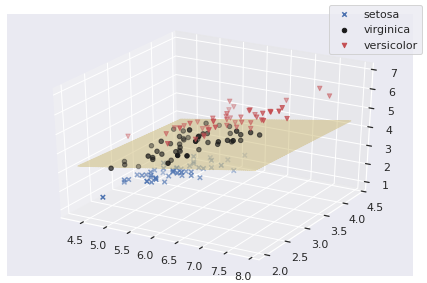

In [7]:
visualize(x_hat)

How good is our separating plane as a classifier? Let's measure its classification accuracy on the training data. Given a data point $a$, we will compute the classifier's prediction for the $i$-th sample as

$$\hat{b_i} = \textrm{round}(A_{i} x)$$

where $A_i$ is the $i$-th row of $A$ and the $\textrm{round}$ function rounds its input to the nearest integer. We treat the classification as correct if $\hat{b}_i = b_i$.

#### **TASK 3**
Fill in the function below so that it computes the accuracy of $\hat{x}$ on $A$. Call the function on the $\hat{x}$ you computed in Task 2. You should obtain > 95% accuracy.

In [8]:
# TODO: Your code here.
def accuracy(x):
  """Return the accuracy of the linear separator x on the training data."""
  
  b_hat = torch.round(torch.matmul(A,x))
  
  accuracy = torch.sum(b == b_hat)/b_hat.size()[0] * 100

  print(f"Accuracy is {accuracy:.2f}%")

accuracy(x_hat)

Accuracy is 96.00%


## Linear regression using SGD

Look, I would love to live in a world where every machine learning problem looks like least squares regression. But in reality, most models do not have a closed form solution. Instead, they require some kind of iterative optimization. Let's pretend for a second that least squares falls under that umbrella and recompute $\hat{x}$ using **stochastic gradient descent**.

The first step is to define the model we want to optimize. The term for "something you can optimize" in PyTorch is a **module**. At a high level, modules (a) store the parameters of the model and (b) know how to map inputs to outputs.

To define a torch module, you must create a class that inherits from `torch.nn.Module`. The class should have an `__init__` function, which initializes any submodules or parameters, and a `forward` function, which takes any number of arguments and performs the computation, returning the result. We provide a skeleton for the linear regression module below.

#### **TASK 4**

Fill in the LinearRegressionModel class and instantiate it.

**Hint**: You should only need to add two lines of code to the class. Check out the `torch.nn.Linear` module, and remember we already accounted for a bias term when we augmented $A$ it Task 1, so you'll want to set `bias=False`.

In [9]:
from torch import nn

class LinearRegressionModel(nn.Module):

  def __init__(self, n_features):
    super().__init__()
    self.m = nn.Linear(n_features,1,bias=False,device=device)
  
  def forward(self, features):
    return self.m(features).to(device)

LM = LinearRegressionModel(A.shape[1])

Now PyTorch knows about our model. Implicitly, torch also knows what **learnable parameters** belong to our model--if you used the `torch.nn.Linear` module in your implementation, the sole parameter is the weight vector stored in `the_linear_module.weight.data`. But I don't have to tell you this: you can obtain a dictionary mapping parameter name to value by calling `model.parameters()`.

When we feed inputs to our model, we call it like a function: `outputs = model(inputs)`. Under the hood, torch will record the operations (such as matrix multiplication, vector addition, etc.) that were used to create `outputs` from `inputs`. This allows torch to compute gradients, which will in turn let us perform gradient descent on the parameters of the model.

Before we can do that, though, we need an objective function, since the gradient we want to compute is the gradient of the _loss_ with respect to the _parameters_. In this case, our objective is the least squares error shown before Task 3. And surprise! It's built into PyTorch:

In [10]:
criterion = nn.MSELoss().to(device)

**Aside:** Notice we pulled the loss function from the `torch.nn` module. That's because loss functions are themselves torch modules, although most of them don't have any parameters or data associated with them. Of course, our loss functions don't have to be torch modules: we could just as well have computed our loss to be `outputs.sum()` or any other scalar value computed from the model outputs. For this class, though, you should probably always use built in loss functions because they often apply some numerical stability tricks under the hood.

Now we have a way to compute a loss from model outputs and target labels. The last important step is to tell torch what to optimize and what optimization method to use. To do this, we must instantiate an `Optimizer` object from the `torch.optim` package. Once you have an `Optimizer`, you can use the magic incantation during training:
```
loss = ...
loss.backward()
optimizer.step()
optimizer.zero_grad()
```
where, as before, `loss` is a scalar tensor computed from your model's outputs. The `loss.backward()` call computes the gradient of the loss with respect to the model parameters used to produce it. The `optimizer.step()` takes the gradient step on the parameters. The `optimizer.zero_grad()` step is not obvious: by default, PyTorch accumulates gradients as you continue to perform computations. We don't want this behavior after we've already taken a gradient step, so we clear the cache each time. Don't forget to do this.

#### **TASK 5**

Instantiate an `Optimizer` below. There are many kinds of optimizers, but for this assignment we'll use basic no-bells no-whistles stochastic gradient descent: `torch.optim.SGD`. Use a learning rate of .01

In [11]:
optimizer = torch.optim.SGD(LM.parameters(), lr=0.01)

Finally, in the spirit of _stochastic_ gradient descent, we will process our training data in batches. This is, of course, _absurdly unnecessary_ for a dataset with only 150 points, but the data utilities in PyTorch are quite useful, and you should know how to use them.

The two classes you'll see over and over again are `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`.

The [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class defines an abstract interface for datasets: you must define `__getitem__`, which returns the features and class label of one item in the dataset, and `__len__`, which returns the number of items in the dataset.

The [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class wraps a given dataset, allowing you iterate over the dataset in batches. No need to worry about indexing or collating the data because it does that for you.

#### **TASK 6**

Fill in the `IrisDataset` skeleton below. Instantiate the dataset using `A` and `b` from the previous section, and also instantiate a `DataLoader` with a batch size of 50.

In [12]:
from torch.utils import data

class IrisDataset(data.Dataset):

  def __init__(self, features, labels):
    super().__init__()
    self.features = features
    self.labels = labels
  
  def __getitem__(self, index):
    return self.features[index], self.labels[index]

  def __len__(self):
    return len(self.labels)

# Instantiate Dataset and DataLoader
irisDS = IrisDataset(A,b)
irisDL = data.DataLoader(irisDS, batch_size=50, shuffle=True)

Now we have all the pieces we need to train a least squares classifier with SGD. 

#### **TASK 7**
Using the optimizer, criterion, and data loader you just created, train the least squares classifier for 2500 epochs. By **epoch**, we mean making a full pass through the dataset, i.e. iterating over the `DataLoader` one full time. 

Visualize the learned plane and print the classification accuracy using the utilities from before. Does the result look the same as before?

In [13]:
epochs = 2500

for epoch in range(epochs):
  for batch, (features,labels) in enumerate(irisDL):

    # Obtain predicted labels
    pred_labels = LM(features).squeeze()

    # Magic incantation
    loss = criterion(pred_labels, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

tensor([-0.2673,  0.0831,  0.5606, -0.7565], device='cuda:0',
       grad_fn=<SelectBackward>)
Accuracy is 96.00%


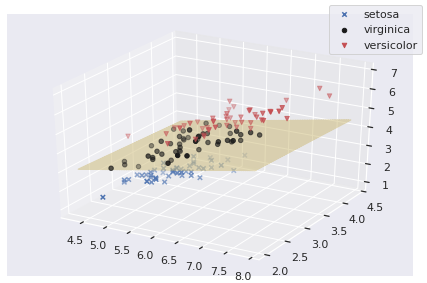

In [14]:
for param in LM.parameters():
  x_hat = param[0]

print(x_hat)

accuracy(x_hat)
visualize(x_hat)

# Part 2: Dynamic Programming

In the second part of this assignment, we will review **dynamic programming**. Dynamic programming (DP) is a paradigm for optimizing recursive algorithms by memoizing and reusing solutions to smaller subproblems.

Many algorithms we will see in this class (e.g., the forward-backward algorithms of HMMs, the CKY parsing algorithm, etc.) rely on dynamic programming for efficient implementation. For that reason, it is important that you are familiar with DP and know how to design and implement new dynamic programs.

## Problem statement

This problem concerns the **edit distance** between strings. Specifically, given two strings like "masaachusets" and "massachusetts", how many characters do we have to add, delete, or change in the first string to make it equal to the second? In this example, the answer should be 2: the second string can be obtained by changing the second "a" to "s" and inserting a "t" near the end.

Formally let $s = s_1 s_2 \dots s_k$ and $t = t_1 t_2 \dots t_\ell$ be strings with $k$ and $\ell$ characters, respectively. The question is: what is the fewest number of character-level edits you can make to $s$ to make it equal to $t$? We will count only four kinds of edits:
1. **Insertionn:** Add a character to the string. Example: $abc \to aabc$.
1. **Deletio:** Delete a character in the string. Example: $abc \to ac$.
1. **Substitutiom:** Replace one character in the string for any other character. Example: $abc \to abd$.
1. **Transpsoition:** Swap two consecutive characters. Example: $abc \to acb$. 
Importantly, we will assume each character is transposed at most one time. So, for example, we will not consider two step transpositions like the following: $abc \to acb \to cab$. Instead, computing edit distance for the previous example would rely on substitutions only

**Caveat:** we will consider some classes of edits as more expensive than others. There are practical reasons to do this. For example, you could imagine using edit distance in a spell checker system, where some kinds of edits are more unlikely (higher cost) than others. In this assignment, we will say that substituting or transposing a consonant with a vowel, or vice versa, is twice as expensive as substituting/transposing within character class, e.g. editing $abc \to abd$ counts as 1 edit, but editing $abc \to aba$ counts as 2.

Write an explicit recurrence relation that solves this problem. Then implement the recurrence using dynamic programming inside the `distance` function below.

**Hint:** Imagine you already know the edit distance between every length $i < k$ prefix of $s$ and length $j < \ell$ prefix of $t$. Can you write the distance between the full $s$ and $t$ in terms of those distances?

**P.S.:** Yes, edit distance is a well known and well studied DP problem. You can probably find solutions online, but **please don't do this.** This assignment is intended to help prepare you for the harder DP assignments coming later in the semester.

In [15]:
# TODO: Your code here.
def distance(s, t):
  """Return the edit distance between strings s and t."""
  

Here are some test cases to help you out. Feel free to add more.

In [16]:
assert distance('masaachusets', 'massachusetts') == 3
assert distance('foo', 'oof') == 2
assert distance('foobarbaz', 'fobabrazr') == 3
assert distance('dpisfun', 'dpnotfun') == 3
print('You did it!')

AssertionError: ignored